In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import torch
import torchvision.models as models

RANDOM_SEED = 123
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(RANDOM_SEED)

# Load pre-trained MobileNetV2 and adjust the classifier for 10 classes
model_mobile = models.mobilenet_v2()
num_ftrs_mobile = model_mobile.classifier[1].in_features
model_mobile.classifier[1] = torch.nn.Linear(num_ftrs_mobile, 10)  # CIFAR-10 has 10 classes

# Load your trained model's weights
model_mobile.load_state_dict(torch.load('/2.4 F1-0.89.pt'))
model_mobile.eval()
model_mobile.to(device)

# Load pre-trained DenseNet121 and adjust the classifier for 10 classes
model_dense = models.densenet121(pretrained=True)
num_ftrs_dense = model_dense.classifier.in_features
model_dense.classifier = torch.nn.Linear(num_ftrs_dense, 10)  # Adjust classifier to 10 classes, matching CIFAR-10

# Load your trained model's weights
model_dense.load_state_dict(torch.load('/3.1 F1-(0.9235) DenseNet .pth'))
model_dense.eval()
model_dense.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [8]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset

# Define transformations for both models
transform_mobile = transforms.Compose([
    transforms.Resize((70, 70)),
    transforms.RandomCrop((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_dense = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Ensure dataset can handle both transformations
class CustomDataset(Dataset):
    def __init__(self, root, transform_dense=None, transform_mobile=None):
        self.dataset = datasets.CIFAR10(root=root, train=False, download=True)
        self.transform_dense = transform_dense
        self.transform_mobile = transform_mobile

    def __getitem__(self, index):
        image, label = self.dataset[index]

        if self.transform_dense:
            image_dense = self.transform_dense(image)
        else:
            image_dense = image

        if self.transform_mobile:
            image_mobile = self.transform_mobile(image)
        else:
            image_mobile = image

        return image_mobile, image_dense, label

    def __len__(self):
        return len(self.dataset)

BATCH_SIZE = 128

test_dataset = CustomDataset(root='./data', transform_dense=transform_dense, transform_mobile=transform_mobile)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


100%|██████████| 170498071/170498071 [00:01<00:00, 92977537.97it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data


In [11]:
import torch

def ensemble_predictions(loader, model1, model2, device):
    model1.eval()  # Set the model to inference mode
    model2.eval()  # Set the model to inference mode
    final_predictions = []
    true_labels = []

    with torch.no_grad():  # Turn off gradients to save memory
        for images_mobile, images_dense, labels in loader:
            images_mobile = images_mobile.to(device)
            images_dense = images_dense.to(device)

            outputs_mobile = model1(images_mobile)
            outputs_dense = model2(images_dense)

            # Average the outputs from both models
            outputs = (outputs_mobile + outputs_dense) / 2

            _, predicted = torch.max(outputs, 1)

            final_predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.numpy())

    return final_predictions, true_labels

In [1]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score

def compute_metrics(predictions, labels):
    # Overall accuracy
    accuracy = accuracy_score(labels, predictions)

    # Overall F1-score
    f1_macro = f1_score(labels, predictions, average='macro')

    # Precision, Recall, F1-score for each class
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None)

    return accuracy, f1_macro, precision, recall, f1

In [13]:
def display_results(accuracy, f1_macro, precision, recall, f1, class_labels):
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Overall F1-Score (Macro Average): {f1_macro:.4f}")
    print("\nClass-wise Metrics:")
    for idx, cls in enumerate(class_labels):
        print(f"{cls} - Precision: {precision[idx]:.4f}, Recall: {recall[idx]:.4f}, F1-Score: {f1[idx]:.4f}")

In [14]:
# Assuming 'model_mobile' and 'model_dense' are already loaded and transferred to 'device'
predictions, labels = ensemble_predictions(test_loader, model_mobile, model_dense, device)

# Compute metrics
accuracy, f1_macro, precision, recall, f1 = compute_metrics(predictions, labels)

# Assuming you have defined your class labels corresponding to indices
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
display_results(accuracy, f1_macro, precision, recall, f1, class_labels)

Overall Accuracy: 0.9348
Overall F1-Score (Macro Average): 0.9349

Class-wise Metrics:
airplane - Precision: 0.9288, Recall: 0.9530, F1-Score: 0.9408
automobile - Precision: 0.9782, Recall: 0.9410, F1-Score: 0.9592
bird - Precision: 0.9245, Recall: 0.9310, F1-Score: 0.9278
cat - Precision: 0.8608, Recall: 0.8780, F1-Score: 0.8693
deer - Precision: 0.9547, Recall: 0.9280, F1-Score: 0.9412
dog - Precision: 0.9026, Recall: 0.8900, F1-Score: 0.8963
frog - Precision: 0.9644, Recall: 0.9470, F1-Score: 0.9556
horse - Precision: 0.9525, Recall: 0.9620, F1-Score: 0.9572
ship - Precision: 0.9702, Recall: 0.9430, F1-Score: 0.9564
truck - Precision: 0.9172, Recall: 0.9750, F1-Score: 0.9452


<ipython-input-16-23eb4fd88d11>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(classes))


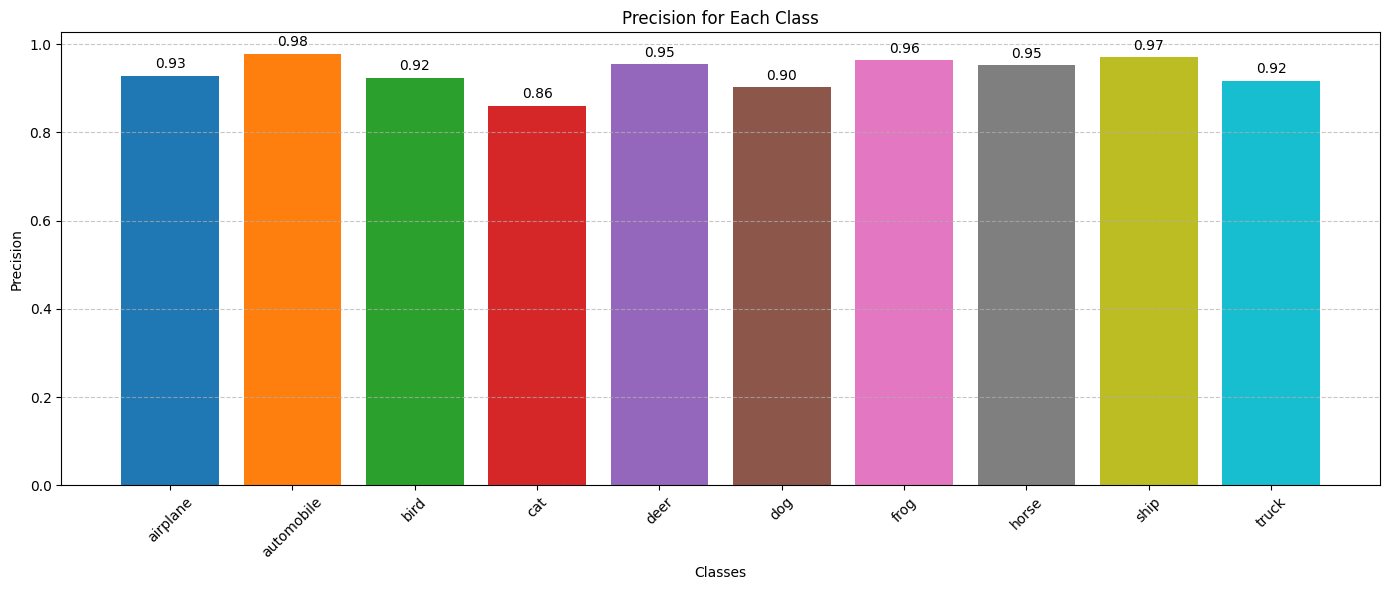

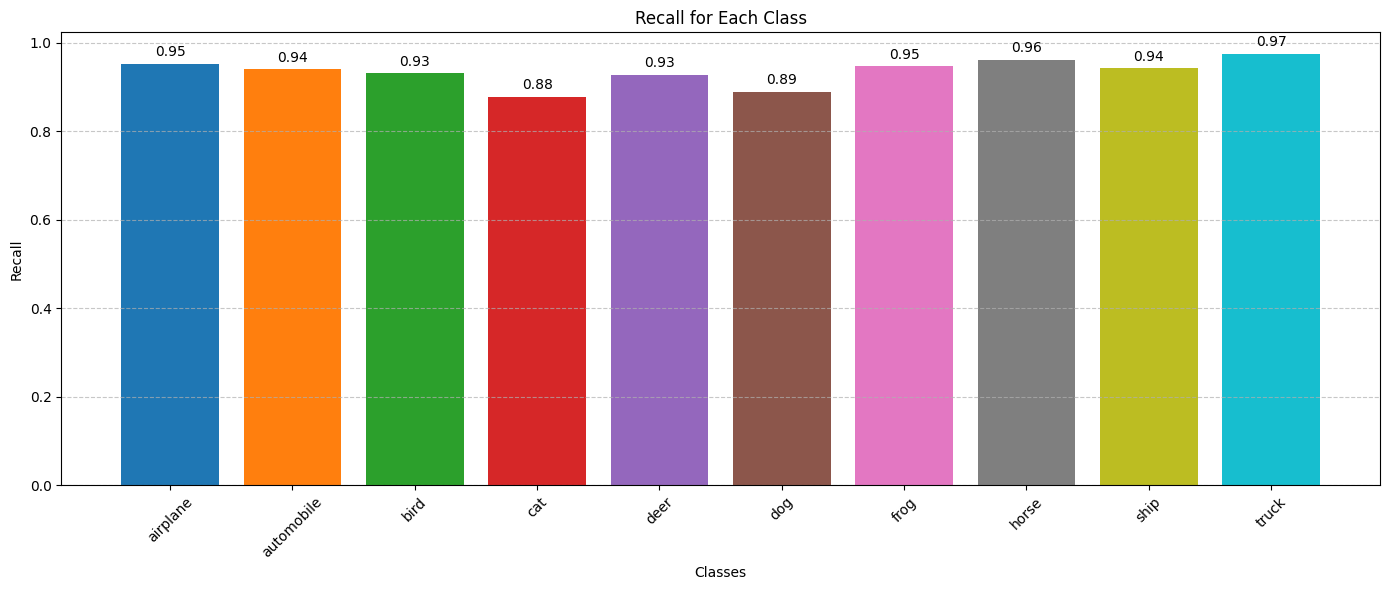

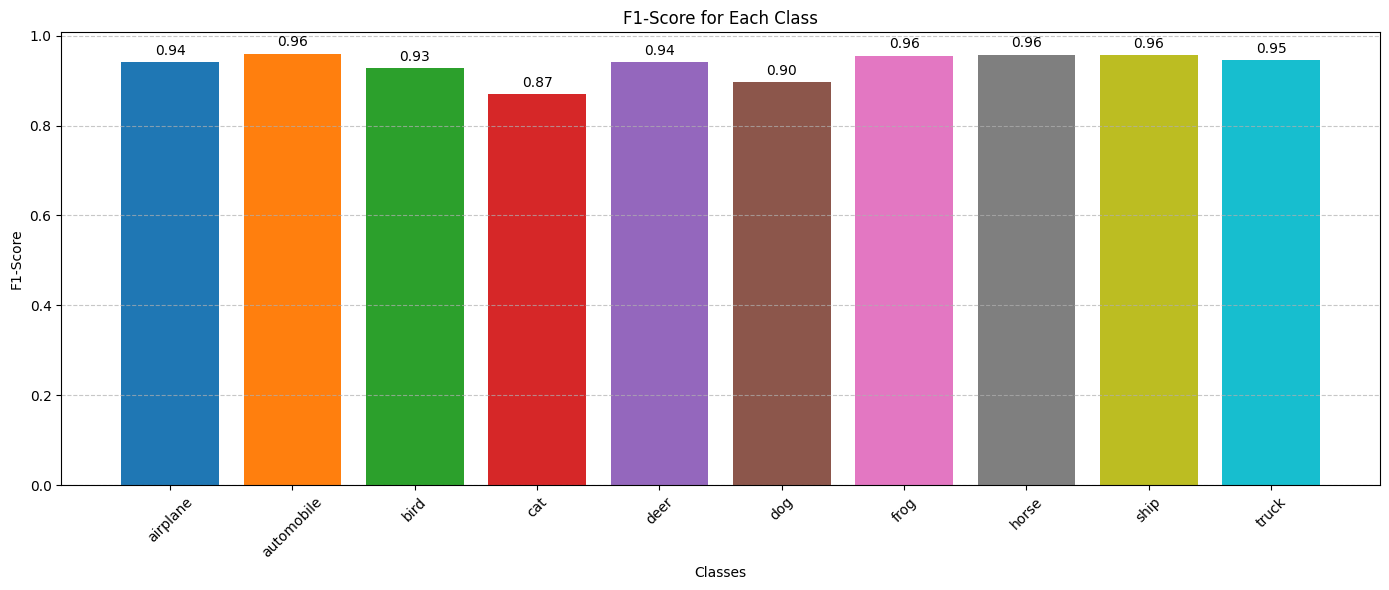

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Define class labels if not already defined
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Define colormap
colors = plt.cm.get_cmap('tab10', len(classes))

# Plot bar charts for each metric
for metric_name, metric_values in zip(['Precision', 'Recall', 'F1-Score'], [precision, recall, f1]):
    plt.figure(figsize=(14, 6))
    bars = plt.bar(classes, metric_values, color=colors(np.arange(len(classes))))
    plt.title(f'{metric_name} for Each Class')
    plt.xlabel('Classes')
    plt.ylabel(metric_name)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add values to the bars
    for bar, value in zip(bars, metric_values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{value:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
